In [1]:
using TSSM
using PyPlot
include("coupled_schroedinger.jl")
include("time_stepper.jl")

 *** OPENMP n_threads =           8


local_orders (generic function with 5 methods)

## Coupled Nonlinear Schrödinger equation

$$\mathrm{i}\left(\frac{\partial \psi_1}{\partial t}+\delta \frac{\partial \psi_1}{\partial x}\right)+\frac{1}{2}\frac{\partial^2\psi_1}{\partial x^2}+(|\psi_1|^2+e|\psi_2|^2)\psi_1=0,\\
\mathrm{i}\left(\frac{\partial \psi_2}{\partial t}+\delta \frac{\partial \psi_2}{\partial x}\right)+\frac{1}{2}\frac{\partial^2\psi_2}{\partial x^2}+(e|\psi_1|^2+|\psi_2|^2)\psi_2=0,\\
$$ and initial condition
$$\psi_1(x,0)=\sum_{j=1}^2\sqrt{\frac{2a_j}{1+e}}\sech(\sqrt{2\alpha_j}x_j)\exp(\mathrm{i}(v_j-\delta)x_j),\\
\psi_2(x,0)=\sum_{j=1}^2\sqrt{\frac{2a_j}{1+e}}\sech(\sqrt{2\alpha_j}x_j)\exp(\mathrm{i}(v_j-\delta)x_j)
$$
where $x_1=x$ and $x_2=x-25$ ande the other parameters as below.

In [2]:
const alpha1=1.0
const alpha2=0.5
const e=2/3.0
const v1=1.0
const v2=0.1
const delta=0.5

xmin=-20
xmax=60
nx=1024

1024

In [3]:
m=CoupledSchroedinger1D(nx,xmin,xmax, delta, e)
psia=wave_function(m)
psi_ref=wave_function(m)
psi=wave_function(m)

#initialcondition
function init1(x)
    (sqrt(2*alpha1/(1+e)) * sech(sqrt(2*alpha1)*(x))    * exp(1im*( (v1-delta)*x )))+
    (sqrt(2*alpha2/(1+e)) * sech(sqrt(2*alpha2)*(x-25)) * exp(1im*( (v2-delta)*(x-25) )))
end

function init2(x)
    (sqrt(2*alpha1/(1+e)) * sech(sqrt(2*alpha1)*(x))    * exp(1im*( (v1+delta)*x )))+
    (sqrt(2*alpha2/(1+e)) * sech(sqrt(2*alpha2)*(x-25)) * exp(1im*( (v2+delta)*(x-25) )))
end

init = Function2(init1,init2)

Function2(init1,init2)

In [4]:
#some schemes
#Emb 4/3 AK p
embedded_scheme_43 = EmbeddedScheme(
          ( 0.125962888700250514,  0.333588446797901933,
            0.751193431379145450, -0.338296598434303506,
            0.127551831557005609,  0.127551831557005609,
           -0.338296598434303506,  0.751193431379145450,
            0.333588446797901933,  0.125962888700250514 ),

          ( 0.125962888700250514,  0.333588446797901933,
            0.751193431379145450, -0.338296598434303506,
            0.0                 ,  0.261153550449697153,
           -0.242703571757396124,  0.596114052266110425,
            0.365547251678000160,  0.147440548920593995 ),

            4 )
#PP 3/4 A
palindromic_scheme_34 = PalindromicScheme( 
          ( 0.268330095781759925,  0.919661523017399857, 
           -0.187991618799159782, -0.187991618799159782, 
            0.919661523017399857,  0.268330095781759925 ),
            3 )
#PP 5/6 A
palindromic_scheme_56 = PalindromicScheme(
          ( 0.201651044312324230,   0.578800656272664932, 
            0.562615975356569200,   0.273128836056524479, 
            0.253874038247554845,  -0.102733803148432142, 
           -0.835351693190370636,   0.068014946093165092, 
            0.068014946093165092,  -0.835351693190370636,
           -0.102733803148432142,   0.253874038247554845, 
            0.273128836056524479,   0.562615975356569200, 
            0.578800656272664932,   0.201651044312324230 ),            
            5 )
#defectbased
embedded_scheme_43_D = DefectBasedScheme(
            embedded_scheme_43.scheme2,
            embedded_scheme_43.order )
palindromic_scheme_34_D = DefectBasedScheme( 
            palindromic_scheme_34.scheme,
            palindromic_scheme_34.order )
palindromic_scheme_56_D = DefectBasedScheme(
            palindromic_scheme_56.scheme,            
            palindromic_scheme_56.order )
schemes=[embedded_scheme_43  ,palindromic_scheme_34  ,palindromic_scheme_56,
         embedded_scheme_43_D,palindromic_scheme_34_D,palindromic_scheme_56_D];

In [5]:
function equidistant_time_stepper(psi::WaveFunction, t0::Real, tend::Real, 
                         dt::Real, es::EmbeddedScheme, 
                         operator_sequence="AB")
    equidistant_time_stepper(psi, t0, tend, dt, es.scheme2,
                         operator_sequence)
end 
function equidistant_time_stepper(psi::WaveFunction, t0::Real, tend::Real, 
                         dt::Real, es::DefectBasedScheme, 
                         operator_sequence="AB")
    equidistant_time_stepper(psi, t0, tend, dt, es.scheme,
                         operator_sequence)
end 
function equidistant_time_stepper(psi::WaveFunction, t0::Real, tend::Real, 
                         dt::Real, ps::PalindromicScheme, 
                         operator_sequence="AB")
    equidistant_time_stepper(psi, t0, tend, dt, ps.scheme,
                         operator_sequence)
end 
function step!(psi::WaveFunction, dt::Real, scheme::EmbeddedScheme, operator_sequence="AB")
    step!(psi,dt,scheme.scheme2,operator_sequence)
end
function step!(psi::WaveFunction, dt::Real, scheme::PalindromicScheme, operator_sequence="AB")
    step!(psi,dt,scheme.scheme,operator_sequence)
end
function step!(psi::WaveFunction, dt::Real, scheme::DefectBasedScheme, operator_sequence="AB")
    step!(psi,dt,scheme.scheme,operator_sequence)
end
function calc_stepmin(psi_ref,psia,psi,scheme,soliton)
            h=1.0
            chg=h/2
            #@printf("||psi_a-psi_ref||=%5.3E ,stepmin= %5.3E,h=%5.3E \n",distance(psia,psi_ref),stepmin,h)
            set!(psi, soliton) 
            while chg>1e-5 || distance(psia,psi_ref) < distance(psi,psi_ref)
                set!(psi, soliton) 
                time = @elapsed for t in equidistant_time_stepper(psi, t0, tend, h, scheme, "AB")
                end
                #@printf("||psi-psi_ref||=%5.3E,  h=%5.3E \n",distance(psi,psi_ref),h)
                if distance(psia,psi_ref) < distance(psi,psi_ref)
                    h=h-chg
                else
                    h=h+chg
                end
                chg=chg/2
            end
    return h
end

calc_stepmin (generic function with 1 method)

In [13]:
  tend=50.0
  t0=0.0
  tol=-5
  scheme=embedded_scheme_43
  out=0
  stepmin_ex=1

1

In [7]:
set!(psi_ref, init)
@time for t in adaptive_time_stepper(psi_ref, t0, tend, 0.1, 1e-12, palindromic_scheme_56, "AB")
end
#@printf("||psi-psi_ref||=%E, ||psi_a-psi_ref||=%E \n",distance(psi,psi_ref),distance(psia,psi_ref))

 69.123768 seconds (9.91 M allocations: 28.251 GB, 2.14% gc time)
||psi-psi_ref||=NaN, ||psi_a-psi_ref||=NaN 


In [14]:
  x = get_nodes(m.m1)
  u1 = get_data(psia.psi1, true)
  u2 = get_data(psia.psi2, true)
  stepsa=[0.0]
  mytimea=[0.0]
  nstepsa=0
  steps=[0.0]
  mytime=[0.0]
  nsteps=0
  set!(psia, init)
  set!(psi, init)

  plotdata1=abs(u1).^2
  plotdata2=abs(u2).^2
  told=0.0



timea = @elapsed for t in adaptive_time_stepper(psia, t0, tend, 0.1, 10.0^tol, scheme, "AB")
  push!(stepsa,t-told)
  push!(mytimea,t)
  told=t
  nstepsa=nstepsa+1
  if out==1
     to_real_space!(psia.psi1)
     to_real_space!(psia.psi2)
     plotdata1 = [plotdata1 abs(u1).^2]
     plotdata2 = [plotdata2 abs(u2).^2]
  end
  end

  stepmin=minimum(stepsa[2:end-1])
if stepmin_ex==1
    stepmin=calc_stepmin(psi_ref,psia,psi,scheme,init)
end
set!(psi, init) #compute again with constant stepsize.
  nsteps=0
  told=0

time = @elapsed for t in equidistant_time_stepper(psi, t0, tend, stepmin, scheme, "AB")
  push!(steps,t-told)
  push!(mytime,t)
  told=t
  nsteps=nsteps+1
  if out==1
    #@printf("t=%5.3f\n", t)
  end
  end

@printf("TOL | steps adaptive | steps equidist | time adaptive | time equidist \n")
@printf("E%d |            %d |           %d |         %5.3f |        %5.3f  \n",tol,nstepsa,nsteps,timea,time)


TOL | steps adaptive | steps equidist | time adaptive | time equidist 
E-5 |            1032 |           2560 |         4.832 |        3.254  


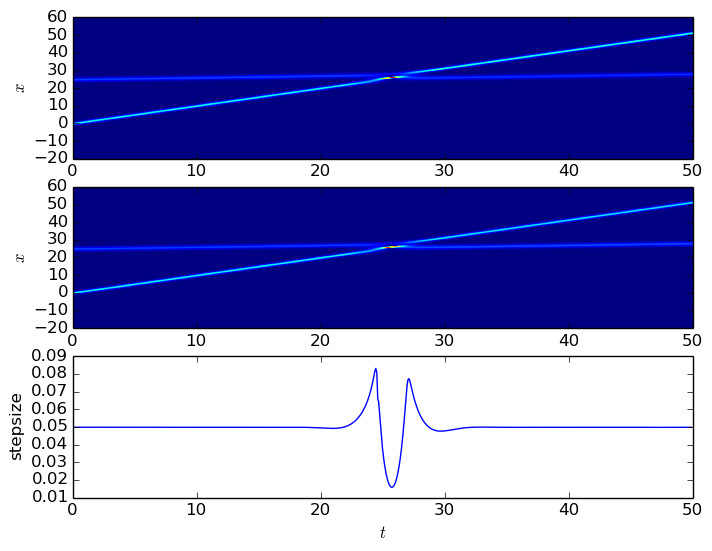

In [12]:
  figure(1)
  hold(false)
  if out==1
  subplot(3, 1, 1)
  pcolormesh(mytimea,x,plotdata1)
  xlabel("\$t\$")
  ylabel("\$x\$")
  subplot(3, 1, 2)
  pcolormesh(mytimea,x,plotdata2)
  xlabel("\$t\$")
  ylabel("\$x\$")
    #colorbar()
  axis([t0,tend,xmin,xmax])
  subplot(3, 1, 3)
  end
  plot(mytimea[1:end-2], stepsa[2:end-1])
  xlabel("\$t\$")
  ylabel("stepsize")
savefig("step.png", bbox_inches="tight")